**CV2021 - week5**

**Contents**

  * [Eigenvectors feature descriptors](https://colab.research.google.com/drive/17kwt4Gt6cQKFA9Lv4H74D3KkBBjU0-Fl#scrollTo=qp0qfBSdhajv)
  * [Mean Shift Algorithm](https://colab.research.google.com/drive/17kwt4Gt6cQKFA9Lv4H74D3KkBBjU0-Fl#scrollTo=9dxtOO5K4THt)
  * [Mean Shift Image Segmentation](https://colab.research.google.com/drive/17kwt4Gt6cQKFA9Lv4H74D3KkBBjU0-Fl#scrollTo=fTkJVOLGnkeJ)
  * [EM Image segmentation](https://colab.research.google.com/drive/17kwt4Gt6cQKFA9Lv4H74D3KkBBjU0-Fl#scrollTo=GuhgQnEoQQRX&line=9&uniqifier=1)

**HOMEWORK**
 
 * **2x0.5bp** Using two different *Scikit* algorithms implementations, perform image segmantation in the *Lab* and *RGB* image space. Compare the results.

 * **1bp** Use the *KDTree*, as explained in *w4*, to speed up the *Mean Shift* algorithm. Compare the runtime against the resolution of the input image.

 * **1bp** Using *numpy* arrays and *python* provided data structures, implment the *k-means* clustering algorithm. Apply it as a segmentation method, in the *Lab* image space. Illustrate your results.  

 * **1bp** Using *numpy* arrays and *python* provided data structures, implment the *DBSCAN* clustering algorithm. Write a *colab* demo describing the algorithm, along with your implementation.


2. **Mean Shift Algorithm**

Mean shift clustering aims to discover “blobs” in a smooth density of samples. It is a centroid-based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.


**References**

* [About k-means and Mean Shift](http://vision.stanford.edu/teaching/cs131_fall1617/lectures/lecture13_kmeans_mean_shift_cs131_2016)

* Dorin Comaniciu and Peter Meer, “Mean Shift: A robust approach toward feature space analysis”. IEEE Transactions on Pattern Analysis and Machine Intelligence. 2002. pp. 603-619.

* [Scikit MeanShift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)


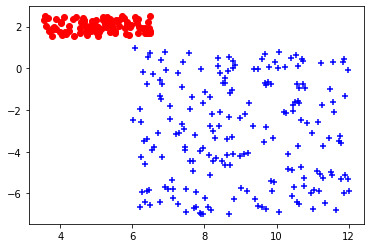

In [4]:
import matplotlib.pyplot as plt 
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np


xs1 = 5  + 3 * (np.random.random((100, )) - 0.5)
ys1 = 2  + (np.random.random((100, )) - 0.5)

xs2 = 9  + 6 * (np.random.random((200, )) - 0.5)
ys2 = -3  + 8 * (np.random.random((200, )) - 0.5)

plt.scatter(xs1, ys1, marker="o", c='red')
plt.scatter(xs2, ys2, marker="+", c='blue')
plt.show()

Next, we should make an assumption about the particularities of the data we are trying to clusterize. More exactly, we will make a rough assumption about the position of the cluster centroid (it's position) and the *spread* (density) of the data characterizing each cluster.

In [5]:
x1 = np.vstack((xs1, ys1))
x2 = np.vstack((xs2, ys2))
data = np.hstack((x1, x2))
print(data.shape)

m1 = np.array([[5], [1.5]])
r1 = 0.3
m2 = np.array([[7], [-6]])
r2 = 1

(2, 300)


In [6]:
def plot_clustering_state(data, means, radius, niter):
  plt.title("After {} iterations".format(niter))
  plt.scatter(data[0, :], data[1, :], marker="+", s=3, color='red')

  circles = []
  for i in range(means.shape[1]):
    circle1 = plt.Circle(means[:, i], radius[i], color='r', fill=False)
    circles.append(circle1)

  for circle in circles:
    plt.gca().add_patch(circle)


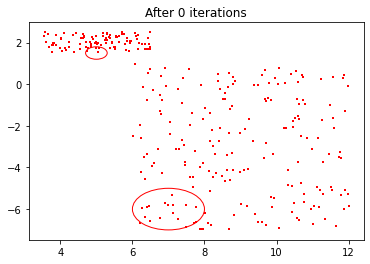

In [7]:
means = np.hstack((m1, m2))
radius = [r1, r2]
plot_clustering_state(data, np.hstack((m1, m2)), [r1, r2], 0)

In [8]:
# Now let's implement the mean shift procedure
means = np.hstack((m1, m2))
radius = [r1, r2]


def cluserize_mean_shift(data, mean_init, rad_init, maxiter):
  niter = 0
  while niter < maxiter:
    # Find all datapoints in the local neighborhood
    for j in range(means.shape[1]):
      mean = means[:, j]
      local_points = []
      for i in range(data.shape[1]):
        diff = data[:, i] - mean
        if np.inner(diff, diff) < radius[j] ** 2:
          local_points.append(data[:, i])

      local_pts = np.array(local_points).T
      means[:, j] = local_pts.mean(axis=1)
    niter += 1
  plot_clustering_state(data, means, radius, niter)

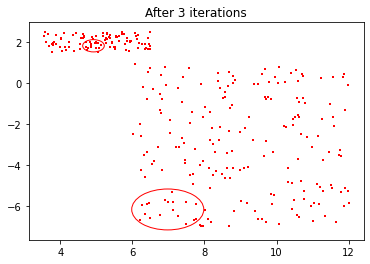

In [9]:
cluserize_mean_shift(data, mean_init=means, rad_init=radius, maxiter=3)

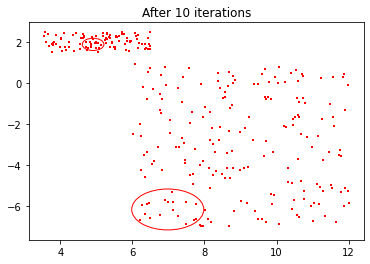

In [10]:
cluserize_mean_shift(data, mean_init=means, rad_init=radius, maxiter=10)

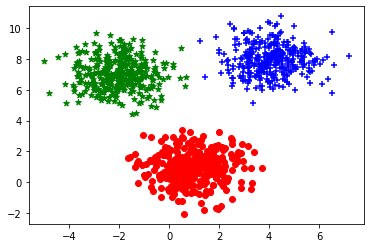

In [11]:
from sklearn.datasets import make_blobs
centers = np.array([[1, 1], [4, 8], [-2, 7]])
colors = ["red", "blue", "green"]
labels= ['o', '+', '*']

X, y = make_blobs(n_samples=1000, centers=centers, n_features=2, random_state=0)

x = X.T
for i in range(x.shape[1]):
  plt.scatter(x[0, i], x[1, i], marker=labels[y[i]], c=colors[y[i]])


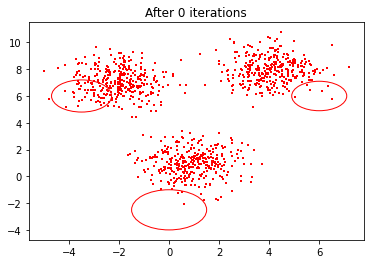

In [12]:
m1 = np.array([[0], [-2.5]])
r1 = 1.5
m2 = np.array([[6], [6]])
r2 = 1.1
m3 = np.array([[-3.5], [6]])
r3 = 1.2

means = np.hstack((m1, m2, m3))
radius = [r1, r2, r3]
cluserize_mean_shift(x, mean_init=means, rad_init=radius, maxiter=0)

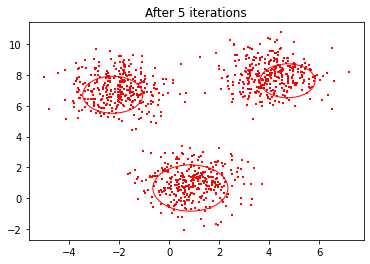

In [13]:
cluserize_mean_shift(x, mean_init=means, rad_init=radius, maxiter=5)

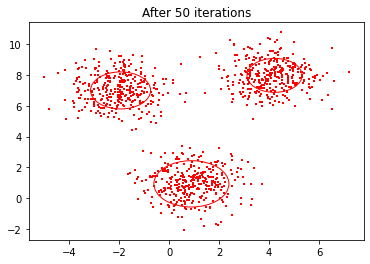

In [14]:
cluserize_mean_shift(x, mean_init=means, rad_init=radius, maxiter=50)

**Mean Shift image segmentation**

In this task, we are going to apply the **MeanShift** algorithm as an Image Segmentation solution. The segmentation aims labeling semantically correct uniform regions as clusters of pixels, in the image representation space.

In [15]:
# this function is going to receive the vectorized Lab image
# the value of the pixel labeled
# the radius for the ball in Lab space used for MeanShift
def find_peak(img, x1, r):
  old_mean = np.zeros((3, 1))
  new_mean = x1.astype(np.float32)
  num_samples = img.shape[1]
  iter = 0

  while np.linalg.norm(new_mean - old_mean) > 1e-5 and iter < 10:
    iter += 1

    distances = np.zeros(num_samples)
    for j in range(num_samples):
      distances[j] = np.linalg.norm(img[:, j] - new_mean)
    
    neighbors_idx = np.argwhere(distances < r)

    neighbors = img[:, neighbors_idx].squeeze(-1) # img should be 3xnum_samples
    if neighbors.shape[1] > 0:
      old_mean = new_mean
      new_mean = neighbors.mean(axis=1)
    else:
      break
  
  return new_mean


def mean_shift_segmentation(img, radius):
  h, w, _ = img.shape
  img = img.astype(np.float32)
  arr_img = np.zeros((3, h * w))
  k = 0

  for i in range(h):
    for j in range(w):
      arr_img[:, k] = img[i, j, :].astype(np.float32)
      k += 1

  # segmentation map
  map = np.zeros((h, w))
  peaks = np.zeros((int(map[i, j]) - 1, h * w))
  k = 0
  for i in range(h):
    for j in range(w):
      
      peak = find_peak(arr_img, img[i, j, :], radius)
      already_in = 0

      # check the existing clusters before adding new ones
      if k > 0:
        for h in range(1, k+1):
          # check the balls corresponding to other clusters
          if np.linalg.norm(peak - peaks[:, h - 1]) < radius / 2:
            already_in = h
            break
        
        # check if the label was found
        if already_in == 0: # add a new label
          k += 1
          map[i, j] = k
          peaks[:, k - 1] = peak
          print((i, j), k, peak)
        else:
          print((i, j), already_in, peaks[:, already_in - 1])
          map[i, j] = already_in # use the found label
          
      else: # first cluster is to be logged
        k += 1
        map[i, j] = k
        peaks[:, k - 1] = peak
        print((i, j), k, peak)
    

  peaks = peaks[:, :k]
  return map, peaks


def visualize_segmentation_map(map):
  plt.rcParams['figure.figsize'] = [8, 4]
  plt.rcParams['figure.dpi'] = 200
  
  h, w = map.shape
  max_colors = int(map.max())
  colors = [np.random.randint(0, 255, size=(3,)).astype(np.uint8) for _ in range(max_colors)]
  output_image = np.zeros((h, w, 3), dtype=np.uint8)
  
  for i in range(int(h)):
    for j in range(int(w)):
      output_image[i, j, :] = colors[int(map[i, j]) - 1]

  plt.imshow(output_image)

 

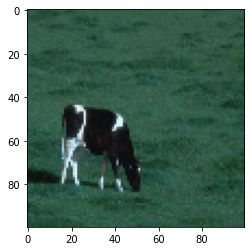

In [17]:
image_cow = cv.imread("cow.jpg")
image_cow = cv.resize(image_cow, (100, 100))
plt.imshow(image_cow)

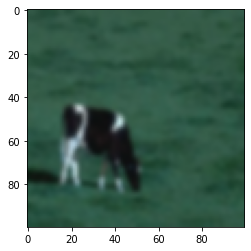

In [18]:
image_cow = cv.GaussianBlur(image_cow,(5, 5), 0)
plt.imshow(image_cow)

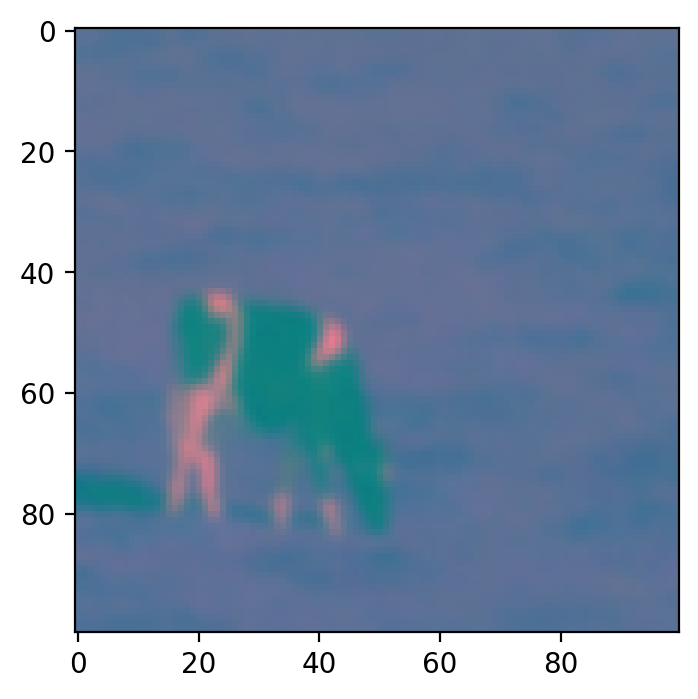

In [72]:
img_lab = cv.cvtColor(image_cow, cv.COLOR_BGR2LAB)
plt.imshow(img_lab)

In [ ]:
map, peaks = mean_shift_segmentation(img_lab.astype(np.float32), radius=15)

In [ ]:
visualize_segmentation_map(map)

## Spectral Clustering Image segmentation

[Source](https://scikit-learn.org/stable/auto_examples/cluster/plot_segmentation_toy.html)

In [26]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


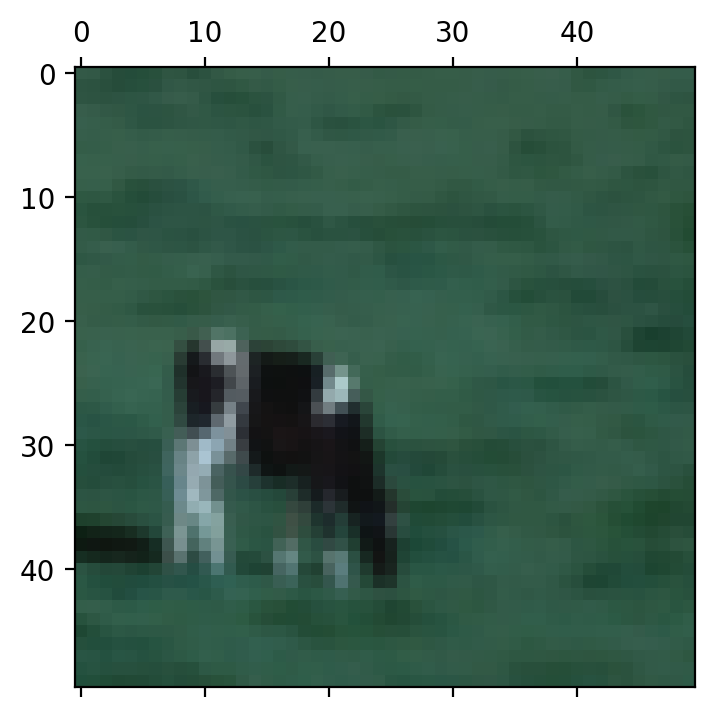

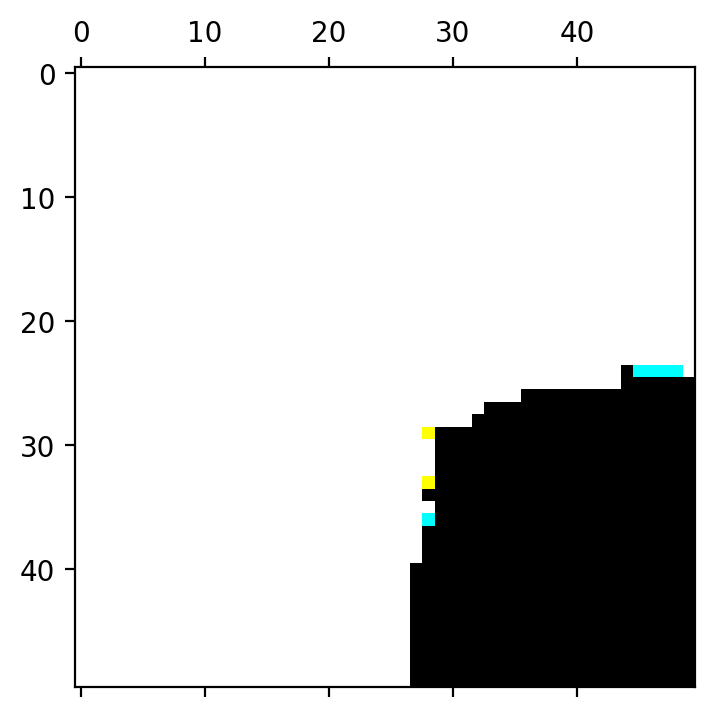

In [97]:
img = image_cow
img = cv.resize(img, (int(img.shape[1]/2),int(img.shape[0]/2)))
mask = img.astype(bool)
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())


labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels
plt.matshow(img)
plt.matshow(label_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


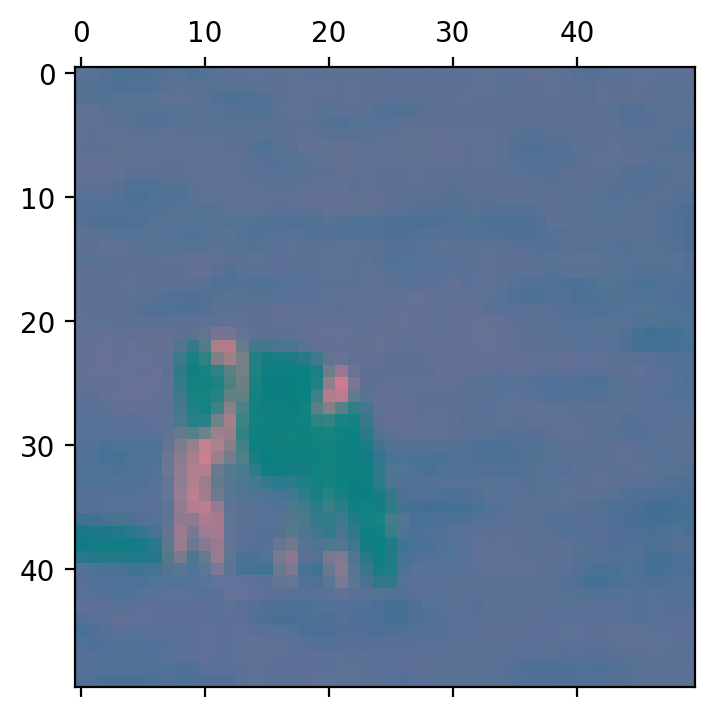

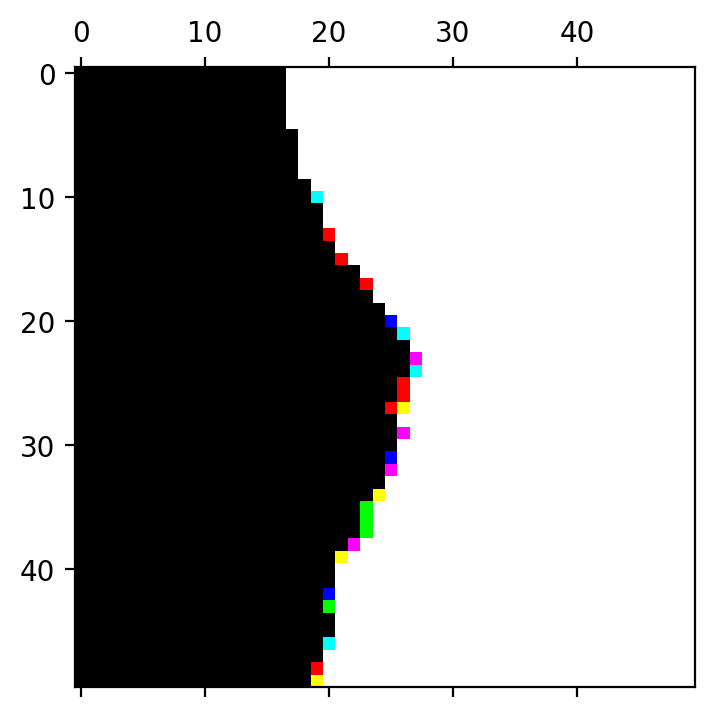

In [101]:
img = img_lab
img = cv.resize(img, (int(img.shape[1]/2),int(img.shape[0]/2)))
mask = img.astype(bool)
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=3, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels
plt.matshow(img)
plt.matshow(label_im)

## DBSCAN Image segmentation

[Source](https://stackoverflow.com/questions/40142835/image-not-segmenting-properly-using-dbscan)

In [70]:
from sklearn.cluster import DBSCAN

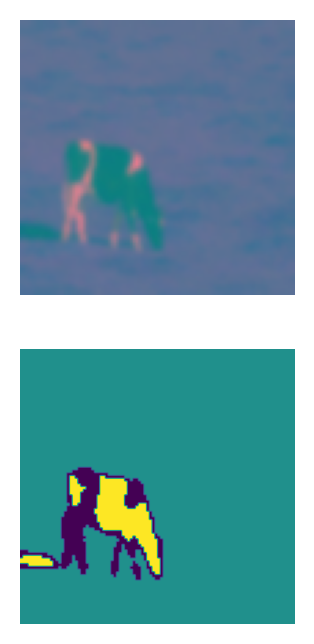

In [104]:
img = img_lab
feature_image=np.reshape(img, [-1, 3])
rows, cols, chs = img.shape

db = DBSCAN(eps=5, min_samples=50, metric = 'euclidean',algorithm ='auto')
db.fit(feature_image)
labels = db.labels_


plt.figure(2)
plt.subplot(2, 1, 1)
plt.imshow(img)
plt.axis('off')


plt.subplot(2, 1, 2)
plt.imshow(np.reshape(labels, [rows, cols]))
plt.axis('off')
plt.show()


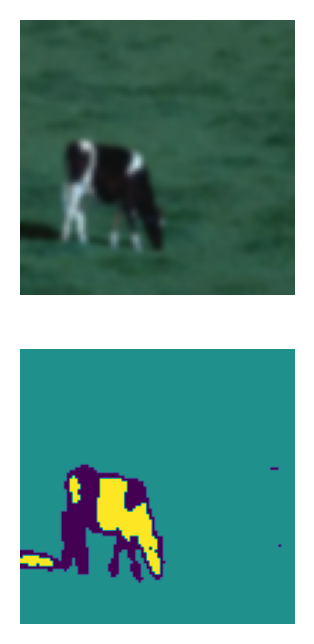

In [93]:
img = image_cow
feature_image=np.reshape(img, [-1, 3])
rows, cols, chs = img.shape

db = DBSCAN(eps=5, min_samples=50, metric = 'euclidean',algorithm ='auto')
db.fit(feature_image)
labels = db.labels_

plt.figure(2)
plt.subplot(2, 1, 1)
plt.imshow(img)
plt.axis('off')


plt.subplot(2, 1, 2)
plt.imshow(np.reshape(labels, [rows, cols]))
plt.axis('off')
plt.show()